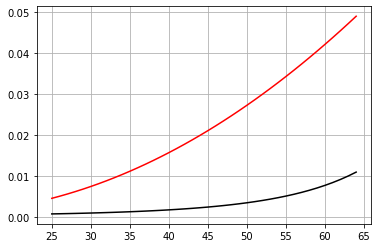

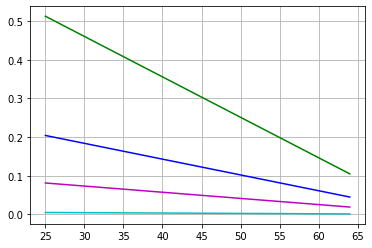

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscount(self,fIRate):# you set v
        vTemp = 1./(1.+fIRate)
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):# you set p_{ij}(t,t+1)
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):# you set a_{i}^{pre}(t) 
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):# you set a_{ij}^{post}(t)
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP # This is Chapman Kolmogorov
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.4f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
                for j in range(self.iNrStates):
                    xBar.append(i+(j)*1./self.iNrStates)
                    hBar.append(self.dGetCF(iStart,iStop,i,j))
                    bBar.append(0)
                    cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1
        

def mua(x):
    return(np.exp(-7.85785 + 0.01538*x + 0.000577355*x**2))

def mui(x):
    return(mua(x)+0.008)

def sigma(x):
    return(3.e-4 * (8.4764-1.0985*x + 0.055*x**2))

def alpha(x,k):
    return(max(0,0.773763-0.01045*(x-k + 1)))

def rx(x,k,n=8):
    if (k>= n): return(0.)
    return(np.exp(-0.94*(k-1)) * alpha(x, k))



x=[]
ix =[]
qx=[]
rxv=[]
rxv1=[]
rxv2=[]
rxv5=[]

for i in range(25,65):
    x.append(i)
    qx.append(mua(i))
    ix.append(sigma(i))
    rxv.append(rx(i,1))
    rxv2.append(rx(i,3))
    rxv1.append(rx(i,2))
    rxv5.append(rx(i,6))

plt.figure(1)
plt.plot(x,qx,"k",x,ix,'r')
plt.grid(True)


plt.figure(2)
plt.plot(x,rxv,'g',x,rxv1,'b',x,rxv2,'m',x,rxv5,'c')
plt.grid(True)


    

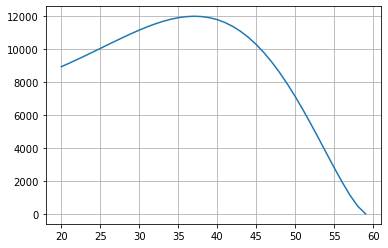

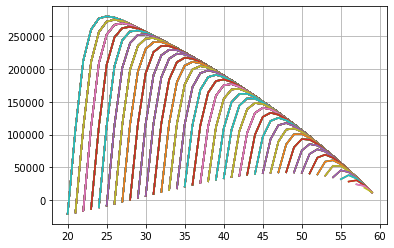

In [13]:
x0 = 20
s  = 60
iRate = 0.015
Annuity = 12000
CostActive = 160
RedToInval = 0.18
CostDisab = 1750
RedFromInval = 1.4
CostActive40 = 7.0
RedActive40 = 0.25



iStart = s
iStop = x0

symM = Markov()
symM.vDefineModel(8+2)
symM.vSetDiscount(iRate)

for i in range(iStop,iStart):
    symM.vSetPij(i,0,0, 1. - sigma(i) - mua(i))
    symM.vSetPij(i,0,1, sigma(i))
    symM.vSetPij(i,0,9, mua(i))
    for j in range(8):
        if j<7: 
            symM.vSetPij(i,1+j,1+j+1, 1.- mui(i)- rx(i,j))
            symM.vSetPij(i,1+j,0, rx(i,j))
        else:
            symM.vSetPij(i,8,8, 1.- mui(i))
            
        symM.vSetPij(i,1+j,9, mui(i))
        symM.vSetPre(i,1+j,1+j,Annuity)
        

symMOpt = Markov()
symMOpt.vDefineModel(8+2)
symMOpt.vSetDiscount(iRate)

for i in range(iStop,iStart):
    symMOpt.vSetPij(i,0,0, 1. - sigma(i) - mua(i))
    symMOpt.vSetPij(i,0,1, sigma(i))
    symMOpt.vSetPij(i,0,9, mua(i))
    symMOpt.vSetPre(i,0,0,0)
    for j in range(8):
        if j<7 and  i > 30: 
            symMOpt.vSetPij(i,1+j,1+j+1, 1.- mui(i)- RedFromInval*rx(i,j))
            symMOpt.vSetPij(i,1+j,0, RedFromInval*rx(i,j))
        elif j<7:
            symMOpt.vSetPij(i,1+j,1+j+1, 1.- mui(i)- rx(i,j))
            symMOpt.vSetPij(i,1+j,0, rx(i,j))    
        else:
            symMOpt.vSetPij(i,8,8, 1.- mui(i))
            
        symMOpt.vSetPij(i,1+j,9, mui(i))
        
        symMOpt.vSetPre(i,1+j,1+j,Annuity+CostDisab)

symMOpta = Markov()
symMOpta.vDefineModel(8+2)
symMOpta.vSetDiscount(iRate)

for i in range(iStop,iStart):
    symMOpta.vSetPij(i,0,0, 1. - sigma(i)*(1-RedToInval) - mua(i))
    symMOpta.vSetPij(i,0,1, sigma(i)*(1-RedToInval))
    symMOpta.vSetPij(i,0,9, mua(i))
    symMOpta.vSetPre(i,0,0,CostActive)
    for j in range(8):
        if j<7: 
            symMOpta.vSetPij(i,1+j,1+j+1, 1.- mui(i)- rx(i,j))
            symMOpta.vSetPij(i,1+j,0, rx(i,j))
        else:
            symMOpta.vSetPij(i,8,8, 1.- mui(i))
            
        symMOpta.vSetPij(i,1+j,9, mui(i))
        
        symMOpta.vSetPre(i,1+j,1+j,Annuity)

        
symMOpt2 = Markov()
symMOpt2.vDefineModel(8+2)
symMOpt2.vSetDiscount(iRate)

for i in range(iStop,iStart):
    if i < 45:
        symMOpt2.vSetPij(i,0,0, 1. - sigma(i)*RedActive40 - mua(i))
        symMOpt2.vSetPij(i,0,1, sigma(i)*RedActive40)
        symMOpt2.vSetPij(i,0,9, mua(i))
    else:
        symMOpt2.vSetPij(i,0,0, 1. - sigma(i) - mua(i))
        symMOpt2.vSetPij(i,0,1, sigma(i))
        symMOpt2.vSetPij(i,0,9, mua(i))
    
    symMOpt2.vSetPre(i,0,0,CostActive40)
    for j in range(8):
        if j<7: 
            symMOpt2.vSetPij(i,1+j,1+j+1, 1.- mui(i)- rx(i,j))
            symMOpt2.vSetPij(i,1+j,0, rx(i,j))
        else:
            symMOpt2.vSetPij(i,8,8, 1.- mui(i))
            
        symMOpt2.vSetPij(i,1+j,9, mui(i))
        
        symMOpt2.vSetPre(i,1+j,1+j,Annuity)

        


x = []
y = []

for i in range(iStop,iStart):
    x.append(i)
    y.append(symM.dGetDK(iStart,iStop,i,0))
    
plt.figure(1)
plt.plot(x,y)
plt.grid(True)

plt.figure(2)
for i in range(iStop,iStart):
    x = []
    y = []
    for j in range(i,iStart):
        x.append(j)
        state = min(8,1+(j-i))
        y.append(symM.dGetDK(iStart,iStop,j,state))
        plt.plot(x,y)
plt.grid(True)
        


    

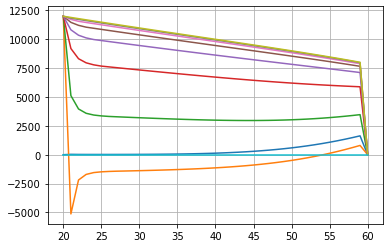

In [3]:
symM.PlotCFs(iStart,iStop)

In [11]:
import os
class MarkovOpt:
    def __init__(self,symMSet):
        self.psymModels =symMSet
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dCF  = []
        self.iOptStrategy = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.iStart = None
        self.iStop  = None
        bCheckConsistency = True
        for i in range(len(symMSet)):
            if symMSet[0].iNrStates != symMSet[i].iNrStates: bCheckConsistency = False
        if not bCheckConsistency: 
            print("Consistency Error -> abort")
            os.abort()
        self.vDefineModel(self.psymModels[0].iNrStates,self.psymModels[0].iMaxTime)
        self.bMin = True # This is not implemented
        self.fStart = 1.e20
    
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            tempStrat = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)
            self.iOptStrategy.append(tempStrat)
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
        
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState], self.iOptStrategy[iAge][iState])
    
    def doCalculateDK(self,iStart,iStop,iAge,iState, myMin=-1.e-20, bChatter = False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
            self.iOptStrategy[i] *=0

        NrStrategies = len(self.psymModels)
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            if bChatter:
                print("===== Recursion t =", i, " ================== ")
            for j in range(self.iNrStates):
                if bChatter:
                    print("--> Analysing State", j, "\n    **********************")
                self.dDK[i][j] = self.fStart
                for l in range(NrStrategies):
                    CandDK = self.psymModels[l].dPre[i][j]
                    for k in range(self.iNrStates):
                        CandDK += self.psymModels[l].dv[i]*self.psymModels[l].dPij[i][j,k]*(self.psymModels[l].dPost[i][j,k]+self.dDK[i+1][k])
                    if CandDK < self.dDK[i][j]:
                        self.dDK[i][j] = CandDK 
                        self.iOptStrategy[i][j] = l
                    if bChatter:
                        print("     Strategy %d  Value %10.2f  OptStartegy %d  ValueOpt %10.2f"%(l, CandDK, self.iOptStrategy[i][j], self.dDK[i][j] ))
                    
    def PrintDKs(self,iStart,iStop,iMaxStates=200):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(min(iMaxStates,self.iNrStates)):
                 strTemp += "  %9.2f [%2d]"%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
            
    def PlotStrategies(self,iStart,iStop):
        Sign = ["bo","ro","cp","mp","yo"]
        plt.figure(1)
        for i in range(iStop,iStart+1):
            for j in range(self.iNrStates):
                x=[i]
                y=[j]
                alpha, beta = self.dGetDK(iStart,iStop,i,j)
                plt.plot(x,y,Sign[int(beta)])
        plt.savefig("exa_opt.png")
    
    def PlotDeltaDK(self,iStart,iStop,iState=0,iFigNr=2):
        plt.figure(iFigNr)
        for l in range(len(self.psymModels)):
            x=[]
            y=[]
            for i in range(iStop,iStart):
                x.append(i)
                y.append(self.psymModels[l].dGetDK(iStart,iStop,i,iState)-self.dGetDK(iStart,iStop,i,iState)[0])
            plt.plot(x,y)
        plt.grid(True)


  20 :    2785.16 [ 0]  -27955.63 [ 0]  102995.92 [ 0]  214336.10 [ 0]  270528.35 [ 0]
  21 :    2901.73 [ 0]  -25652.92 [ 0]  104450.02 [ 0]  212675.85 [ 0]  267033.15 [ 0]
  22 :    3023.48 [ 0]  -23243.08 [ 0]  105812.00 [ 0]  210895.28 [ 0]  263421.92 [ 0]
  23 :    3149.40 [ 0]  -20733.60 [ 0]  107075.19 [ 0]  208990.20 [ 0]  259691.62 [ 0]
  24 :    3278.14 [ 0]  -18132.99 [ 0]  108232.49 [ 0]  206956.23 [ 0]  255839.10 [ 0]
  25 :    3408.00 [ 0]  -15450.62 [ 0]  109276.65 [ 0]  204788.68 [ 0]  251861.09 [ 0]
  26 :    3536.95 [ 0]  -12697.29 [ 0]  110199.86 [ 0]  202483.19 [ 0]  247754.04 [ 0]
  27 :    3662.21 [ 0]   -9807.86 [ 0]  110993.95 [ 0]  200035.24 [ 0]  243515.07 [ 0]
  28 :    3779.22 [ 0]   -6568.23 [ 0]  111318.99 [ 0]  197441.43 [ 0]  239141.49 [ 0]
  29 :    3879.74 [ 0]   -2550.44 [ 0]  109940.12 [ 0]  194041.34 [ 0]  234632.89 [ 0]
  30 :    3937.05 [ 0]    4628.56 [ 0]  103647.34 [ 0]  187497.60 [ 0]  229162.64 [ 0]
  31 :    4215.42 [ 0]  -24421.56 [ 1]   76

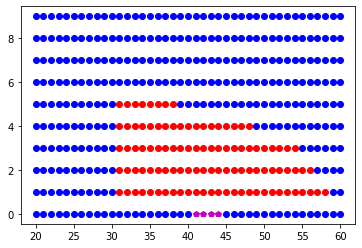

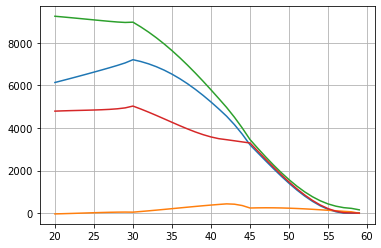

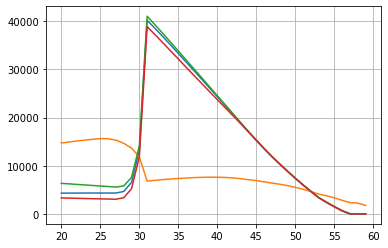

In [14]:
MaOpt = MarkovOpt([symM,symMOpt,symMOpta,symMOpt2])
MaOpt.PlotStrategies(iStart,iStop)
MaOpt.PlotDeltaDK(iStart,iStop,iState=0)
MaOpt.PlotDeltaDK(iStart,iStop,iState=2,iFigNr=3)
MaOpt.PrintDKs(iStart,iStop,iMaxStates=5)
MaOpt2 = MarkovOpt([symM])
print("----")
MaOpt2.PrintDKs(iStart,iStop,iMaxStates=5)